In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import Levenshtein as lev

import matplotlib.pyplot as plt
from arion.utils import generate_db, peakset2ppm, Colors

In [3]:
data_dir = '/media/shared/arion_data/metabolites'

In [4]:
filled = pd.read_csv('filled.csv').iloc[:, 1:]
features = pd.read_csv('features.csv').iloc[:, 1:]
features.shape

(16, 456)

In [5]:
corr_mat = features.corr('spearman')
top_vals = corr_mat > 0.5

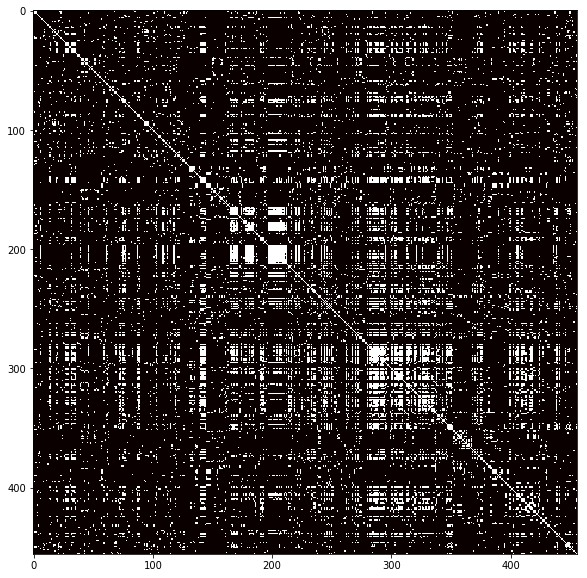

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(top_vals, cmap='hot', interpolation='none')

In [7]:
g = nx.Graph(corr_mat > 0.75)

In [8]:
cliqs = []

MAXCLIQUES = 10000
for idx, cliq in enumerate(nx.find_cliques(g)):
    if idx > MAXCLIQUES:
        raise Exception(f"More than {MAXCLIQUES} cliques found")
        break
    cliqs.append(cliq)
print(f"found {len(cliqs)} cliques")

found 610 cliques


In [13]:
peak_db = generate_db(data_dir)

found 9028 peaks across 615 metabolites


In [ ]:
found = False
identified_metabolites = []
for idx, cliq in enumerate(cliqs):
    res = peak_db.query_n(peakset2ppm(cliq, filled))
    for qs in res:
        if qs['score'] >= 0.25 and len(peak_db.metabolite_peaks[qs['metabolite_id']]) > 1 and len(qs['missing']) < 2:
            identified_metabolites.append((idx, cliq, qs))
            print(qs)

In [18]:
import glob
import xml.etree.ElementTree as ET

data_dir = '/media/shared/arion_data/metabolites'
xml_file = 'simulation_1/spin_simulation.xml'
cutoff = 0.001

peaks = []
met_idx = 0
names = {}
for met_idx, d in enumerate(glob.glob(f'{data_dir}/bmse*')):
    metabolite_id = d.split('/')[-1]

    tree = ET.parse(f'{d}/{xml_file}')
    root = tree.getroot()
    names[root.find('ID').text] = root.find('name').text

In [26]:
import csv

hamid_met_names = []
with open("names_from_hamid.csv") as f:
    csvfile = csv.reader(f)
    next(csvfile)
    for line in csvfile:
        hamid_met_names.append([l.strip() for l in line])

In [24]:
matched_count = 0
unmatched_count = 0

# unmatched_file = open('umatched.csv', 'w')
# writer = csv.writer(unmatched_file)
# writer.writerow([f"Name {i}" for i in range(1, 6)] + [f"suggestion {i}" for i in range(1, 6)])

matched_set = set()
for hamid_met_name_set in hamid_met_names:
    matches = []
    for n in hamid_met_name_set:
        scores = [(n, lev.jaro(n.lower(), m.lower()), (i, m)) for i, m in names.items()]
        matches.append(max(scores, key=lambda a: a[1]))
    
    if any([abs(m[1] - 1) < 0.000001 for m in matches]):
        matched_count += 1
        maxv = max(matches, key=lambda a: a[1])
#         print(maxv)
        matched_set.add(maxv[2][0])
    else:
        orig = [i[0] for i in matches]
        suggestions = [f'{i[2][1]} <{i[2][0]}>' for i in matches]
        
#         writer.writerow(orig + suggestions)
        
        unmatched_count += 1
print(f"matched {matched_count} | unmatched {unmatched_count}")

matched_set.update(['bmse000208', 'bmse000161', 'bmse000373', 'bmse000092', 'bmse000142', 'bmse000182'])
# unmatched_file.close()

matched 68 | unmatched 46


In [25]:
unique_metabolites = {i[2]['metabolite_id'] for i in identified_metabolites}
print(f'identified {len(unique_metabolites)} potential metabolites')
for m in unique_metabolites:
    print(f"{m}({len(peak_db.metabolite_peaks[m])})", Colors.color("found", Colors.OKGREEN) if m in matched_set else Colors.color("not found", Colors.FAIL))

identified 67 potential metabolites
bmse000208(6) found
bmse000161(16) found
bmse000102(4) not found
bmse000157(7) not found
bmse000576(3) not found
bmse000076(4) found
bmse000107(2) not found
bmse000360(8) not found
bmse000363(2) not found
bmse000863(7) found
bmse000288(4) not found
bmse000130(4) not found
bmse000705(2) not found
bmse000538(5) not found
bmse000950(2) not found
bmse000647(6) not found
bmse000881(3) not found
bmse000421(2) not found
bmse000517(4) not found
bmse000905(16) not found
bmse000443(2) not found
bmse000206(4) found
bmse000160(2) found
bmse000709(3) not found
bmse000567(2) not found
bmse000282(6) not found
bmse000834(2) not found
bmse000096(2) not found
bmse000607(2) not found
bmse000155(2) found
bmse000761(4) not found
bmse000979(6) not found
bmse000066(4) not found
bmse000078(4) found
bmse000637(2) not found
bmse000159(6) found
bmse000146(2) not found
bmse000774(2) not found
bmse000418(2) not found
bmse000730(2) not found
bmse000070(3) not found
bmse000384(3) 

## Playground

In [23]:
filled[np.logical_and(filled.peakPPM > 3.09, filled.peakPPM < 3.10)]

,peakIndex,peakPPM,peakValue,peakSNR,peakScale,Sample
2932,39724,3.09768,1645.851751,78.810757,16.0,1
2933,39724,3.09768,1668.194836,16.073119,16.0,2
2934,39724,3.09768,1353.187492,27.515097,16.0,4
2935,39724,3.09768,1442.829691,21.724018,16.0,5
2936,39724,3.09792,799.588237,13.440489,16.0,6
2937,39724,3.09768,1048.566347,25.428368,16.0,7
2938,39724,3.09792,1099.928058,41.239464,15.0,8
2939,39724,3.09792,2318.607778,36.745645,16.0,9
2940,39724,3.09792,1144.814369,29.424182,16.0,10
2941,39724,3.09792,1526.418191,25.952690,16.0,11
